In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [9]:
VIDEO = "shaky cam footage.mov"

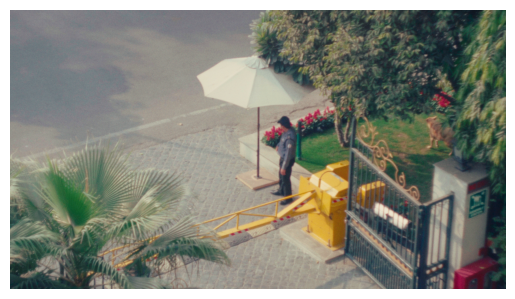

In [4]:
cap = cv.VideoCapture('shaky cam footage.mov')

if not cap.isOpened():
    print("Error: Cant open video or camera.")

ret, frame = cap.read()

if ret:
#display first frame
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    plt.imshow(frame_rgb)
    plt.axis("off")
else:
    print("Error: Cant read the frame.")
cap.release()

In [5]:
def getNthframe(video, frame_number):
    cap = cv.VideoCapture(video)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    if frame_number > total_frames or frame_number < 0:
        print("Error: Requested frame out of bounds")

    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)

    ret,frame = cap.read()
    return frame

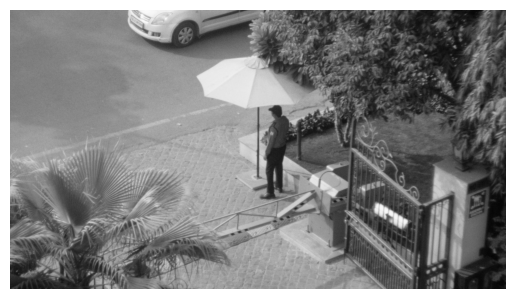

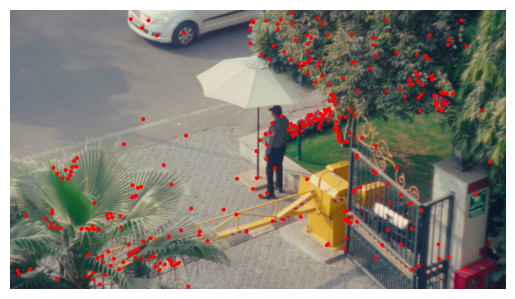

In [6]:
img = getNthframe("shaky cam footage.mov", 200)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray, cmap="gray")
plt.axis("off")

corners = cv.goodFeaturesToTrack(gray,300,0.01,10)
corners = corners.astype(int)
 
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),15,255,-1)

plt.figure() 
plt.imshow(img)
plt.axis("off")
plt.show()

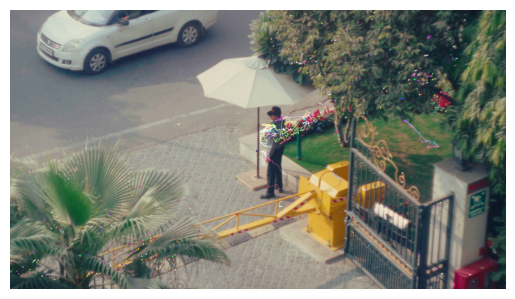

In [ ]:
cap = cv.VideoCapture(VIDEO)

max_corners = 300
quality_level = 0.2
min_distance = 20
block_size = 7

feature_params = dict(
    maxCorners=max_corners,
    qualityLevel=quality_level,
    minDistance=min_distance,
    blockSize=block_size
)

win_size = (15, 15)
max_level = 2
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)

lk_params = dict(
    winSize=win_size,
    maxLevel=max_level,
    criteria=criteria
)

ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params) #shi tomashi feature tracking
colors = np.random.randint(0, 255, (max_corners, 3), dtype=np.uint8)

mask = np.zeros_like(old_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break 

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is None or st is None:
        break

    good_new = p1[st == 1]
    good_old = p0[st == 1]

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()

        col = colors[i % len(colors)].tolist()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), col, 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, col, -1)

    img = cv.add(frame, mask)

    clear_output(wait=True)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    key = cv.waitKey(1) & 0xFF
    if key == ord('q') or key == 27: 
        break

    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cap.release()
cv.destroyAllWindows()